# Dobór hiperparametrów finalnego modelu i ostateczna ocena skuteczności

## Na podstawie wcześniejszej oceny modeli jako ostateczny wybraliśmy model oparty o soft-voting trzech modeli: LogisticRegression, KNeighborsClassifier,  DecisionTreeClassifier

## W celu dobrania optymalnych parametrów zastosujemy grid search

In [34]:
# potrzebne biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from itertools import product
import warnings
warnings.filterwarnings('ignore')

#### Używaliśmy różnych random seed otrzymując zbliżone rexultaty

In [19]:
# globalne ustawinie random seed
np.random.seed = 1

In [32]:
# funkcja do oceny modelu - taka jak w poprzednich plikach

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Zakodowanie etykiet w sposób jednolity
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)  

    # Trening modelu
    model.fit(X_train, y_train_encoded)
    
    # Predykcja na zbiorze treningowym i testowym
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Dokładności
    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    test_acc = accuracy_score(y_test_encoded, y_test_pred)

    # Raporty klasyfikacji
    train_report = classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_.tolist())
    test_report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_.tolist())

    # Precision, Recall, F1 score
    train_precision = precision_score(y_train_encoded, y_train_pred, average='weighted')
    train_recall = recall_score(y_train_encoded, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train_encoded, y_train_pred, average='weighted')

    test_precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
    test_recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

    # Macierze pomyłek
    train_cm = confusion_matrix(y_train_encoded, y_train_pred)
    test_cm = confusion_matrix(y_test_encoded, y_test_pred)

    # Wypisanie wyników
    print(f"\n📊 Dokładność (trening): {train_acc:.4f}")
    print(f"Precision (trening): {train_precision:.4f}")
    print(f"Recall (trening): {train_recall:.4f}")
    print(f"F1 Score (trening): {train_f1:.4f}")
    print("Raport klasyfikacji (trening):\n", train_report)

    print(f"\n📊 Dokładność (test): {test_acc:.4f}")
    print(f"Precision (test): {test_precision:.4f}")
    print(f"Recall (test): {test_recall:.4f}")
    print(f"F1 Score (test): {test_f1:.4f}")
    print("Raport klasyfikacji (test):\n", test_report)

    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(12, 6))

    # Macierz pomyłek dla zbioru treningowego
    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Macierz Pomyłek - Trening")
    plt.xlabel("Przewidywania")
    plt.ylabel("Rzeczywiste")

    # Macierz pomyłek dla zbioru testowego
    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Macierz Pomyłek - Test")
    plt.xlabel("Przewidywania")
    plt.ylabel("Rzeczywiste")

    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()


In [21]:
# Wczytanie danych
train_data = pd.read_csv("train_data_with_features.csv")
test_data = pd.read_csv("test_data_with_features.csv")

# Przygotowanie cech i etykiet
y_train = train_data['class']
X_train = train_data.drop(['class', "path", "filename", "R", "G", "B", "brightness"], axis=1)
y_test = test_data['class']
X_test = test_data.drop(['class', "path", "filename", "R", "G", "B", "brightness"], axis=1)

feature_names = [f"Feature {i}" for i in X_train.columns] #will be needed for shap in the end

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [22]:
# Deklaracja modeli do dalszej optymalizacji

model1 = RandomForestClassifier()
model2 = LogisticRegression( max_iter=1000)
estimators=[('DecisionTree', model1), ('LR', model2)]

## Znajdujemy optymalne parametry dla każdego z prostych modeli i wykorzystujemy soft vote z arbitralnie ustawionymi wagami


📊 Dokładność (trening): 0.9840
Precision (trening): 0.9841
Recall (trening): 0.9840
F1 Score (trening): 0.9840
Raport klasyfikacji (trening):
                       precision    recall  f1-score   support

      Bombali Ghevda       0.97      0.94      0.96       448
        Butka Ghevda       1.00      1.00      1.00       448
       Gabara Ghevda       1.00      1.00      1.00       447
             God Wal       0.96      0.98      0.97       448
          Hirva Lamb       1.00      0.98      0.99       448
            Kadu wal       0.98      0.99      0.98       444
            Kala Wal       0.99      0.99      0.99       448
     Lal lamb shenga       0.98      0.98      0.98       448
Lamb Shiracha Ghevda       0.98      0.99      0.98       448
      Shravan Ghevda       1.00      0.98      0.99       448
          Tambda wal       1.00      1.00      1.00       448
       Vatana Ghevda       0.96      0.97      0.96       448

            accuracy                           0

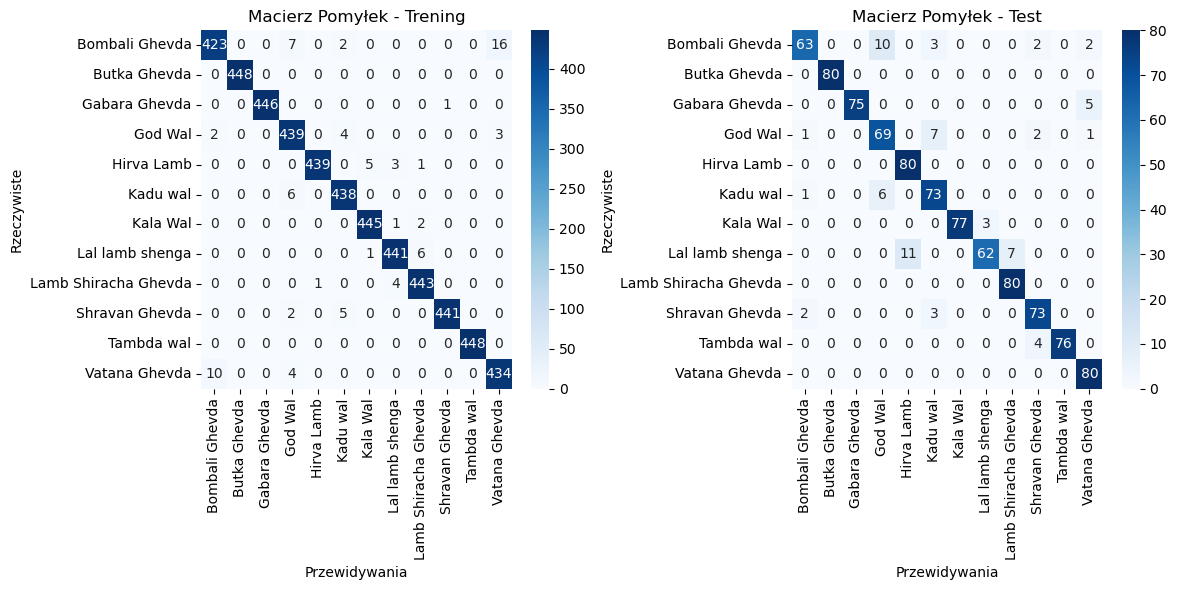

In [27]:
# Parametry dla RandomForest
rf_param_grid = {              
    'max_depth': [None, 5],               
    'min_samples_split': [2, 5],               
    'min_samples_leaf': [ 2, 4],                 
    'max_features': ['sqrt', 'log2'],             
}


# Parametry dla LogisticRegression
# Parametry dla LogisticRegression
lr_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
# Tworzenie obiektów GridSearch dla każdego modelu
rf_grid = RandomizedSearchCV(RandomForestClassifier(), rf_param_grid, n_iter=10,cv=5, scoring='accuracy',n_jobs=-1)
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='accuracy',n_jobs=-1)

# Dopasowanie modeli
rf_grid.fit(X_train, y_train)
lr_grid.fit(X_train, y_train)

# Uzyskanie najlepszych parametrów
best_rf = rf_grid.best_estimator_
best_lr = lr_grid.best_estimator_


model_soft = VotingClassifier(estimators=[('RandomForest', best_rf), 
                                          ('LR', best_lr)], 
                              voting='soft', 
                              weights=[0.4,0.60])

evaluate_model(model_soft, X_train, X_test, y_train, y_test)

## Dla wcześniej zoptymalizowanych prostych modeli dobieramy optymalne parametry
#### obliczone raz w celu doboru parametrów wag, lepiej nie powtarzać

In [ ]:
 # Generowanie wszystkich możliwych wag z krokiem 0.1 (suma wag = 1.0)
 values = np.arange(0.0, 1.1, 0.1)
 combinations = list(product(values, repeat=2))
 valid_weights = [list(comb) for comb in combinations if np.isclose(sum(comb), 1.0)]

 # Parametry do GridSearchCV
 voting_param_grid = {
     'weights': valid_weights
 }

 voting = VotingClassifier(estimators=[
     ('RandomForest', best_rf),
     ('LR', best_lr)
 ], voting='soft')

 voting_grid = GridSearchCV(estimator=voting, param_grid=voting_param_grid, cv=5, scoring='accuracy')
 voting_grid.fit(X_train, y_train)

 best_voting = voting_grid.best_estimator_

best_voting.get_params

<bound method _BaseHeterogeneousEnsemble.get_params of VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(max_features='log2',
                                                     min_samples_leaf=2)),
                             ('LR', LogisticRegression(C=10, max_iter=1000))],
                 voting='soft', weights=[0.6000000000000001, 0.4])>


📊 Dokładność (trening): 0.9957
Precision (trening): 0.9957
Recall (trening): 0.9957
F1 Score (trening): 0.9957
Raport klasyfikacji (trening):
                       precision    recall  f1-score   support

      Bombali Ghevda       1.00      0.98      0.99       448
        Butka Ghevda       1.00      1.00      1.00       448
       Gabara Ghevda       1.00      1.00      1.00       447
             God Wal       0.98      0.99      0.99       448
          Hirva Lamb       1.00      1.00      1.00       448
            Kadu wal       0.99      0.99      0.99       444
            Kala Wal       1.00      1.00      1.00       448
     Lal lamb shenga       1.00      1.00      1.00       448
Lamb Shiracha Ghevda       1.00      1.00      1.00       448
      Shravan Ghevda       1.00      1.00      1.00       448
          Tambda wal       1.00      1.00      1.00       448
       Vatana Ghevda       0.99      0.99      0.99       448

            accuracy                           1

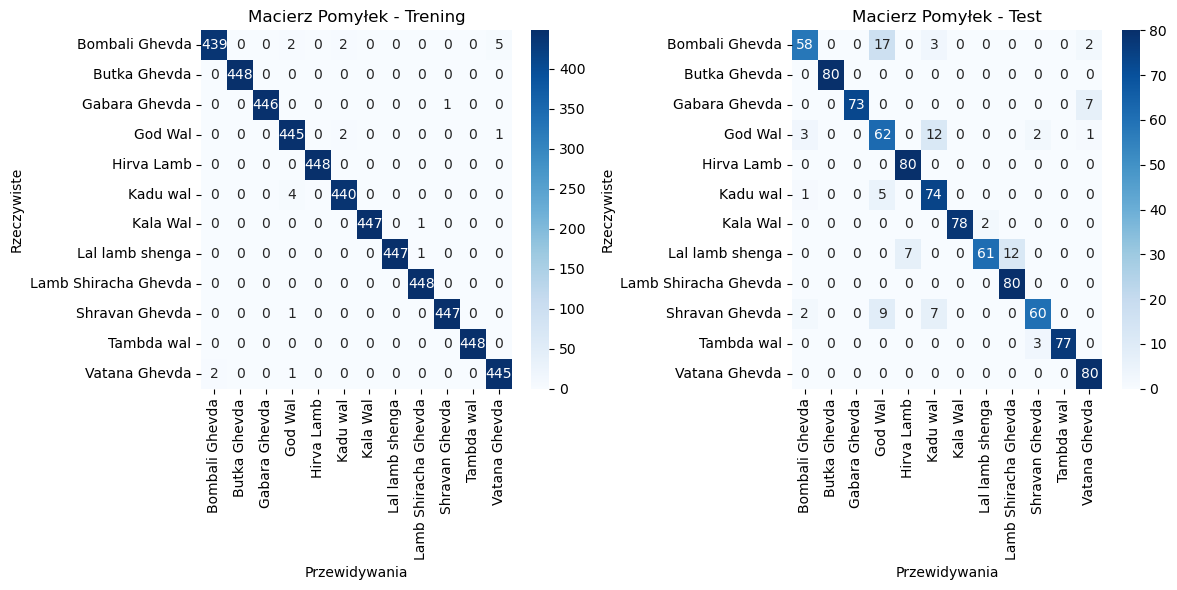

In [ ]:
best_voting.fit(X_train, y_train)
evaluate_model(best_voting, X_train, X_test, y_train, y_test)

## Ocena inerpretowalności modelu
#### ocena na mniejszej próbce ze względu na złożoność obliczeniową

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

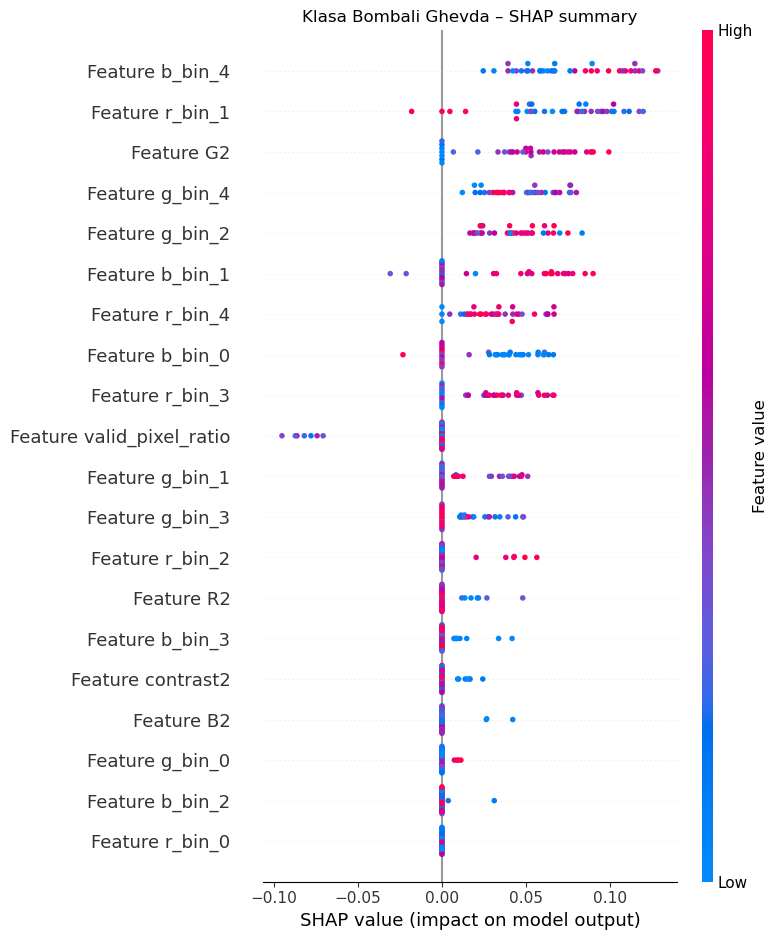

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

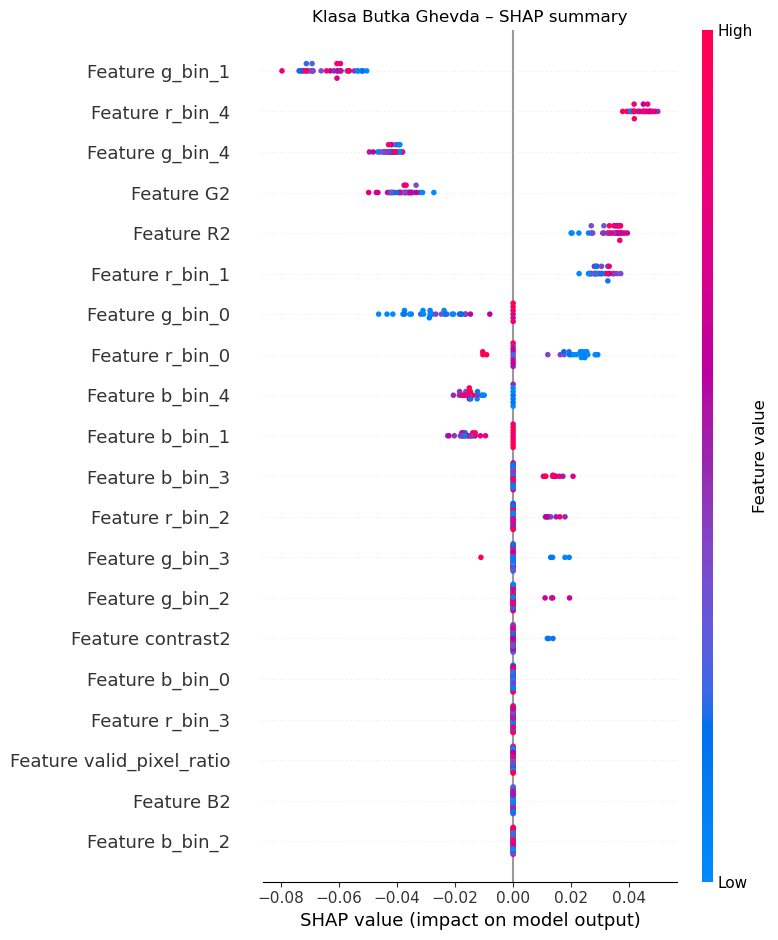

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

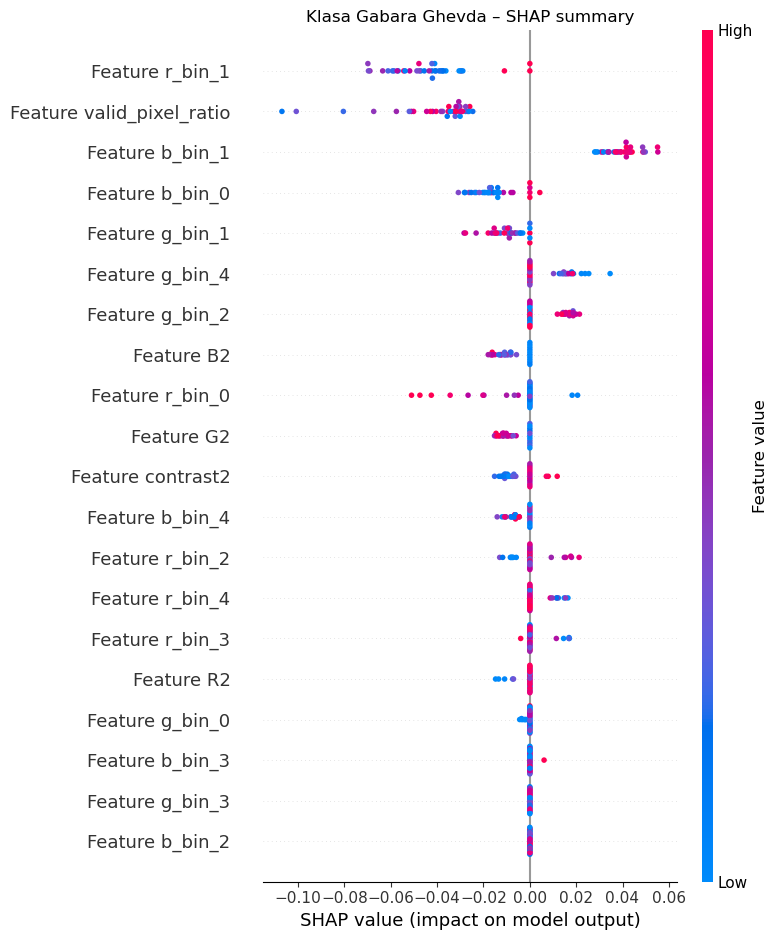

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

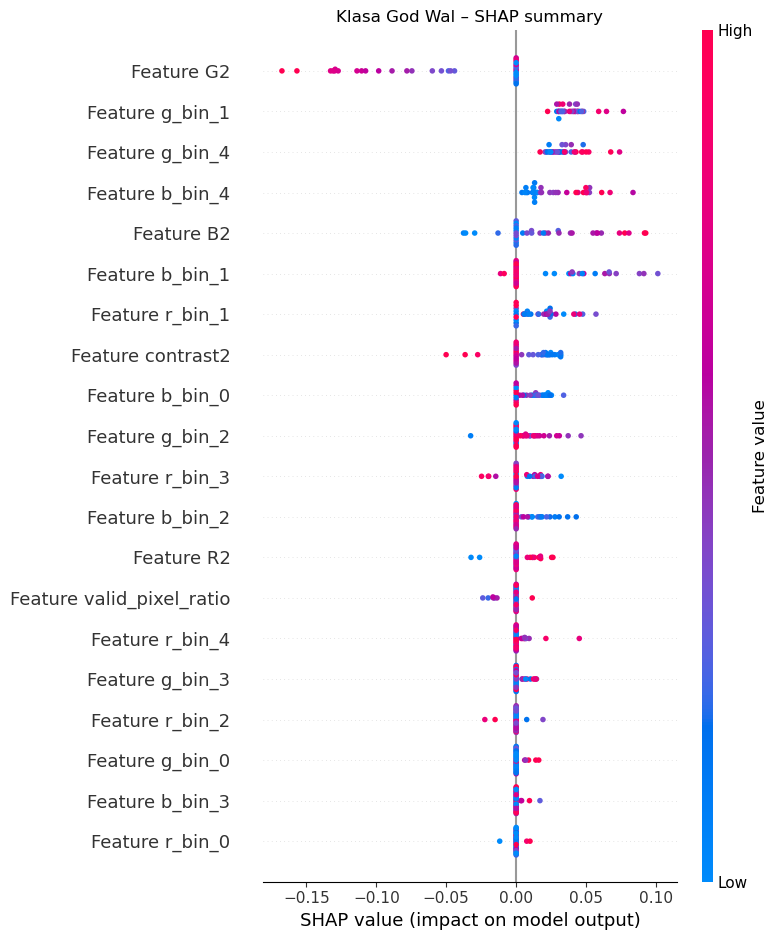

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

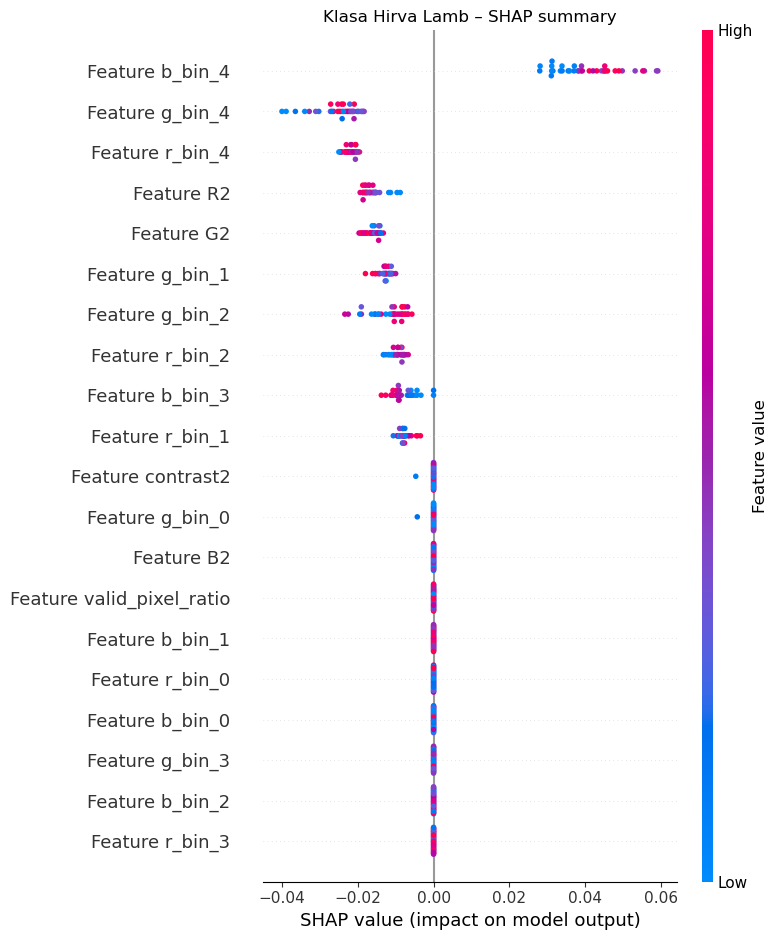

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

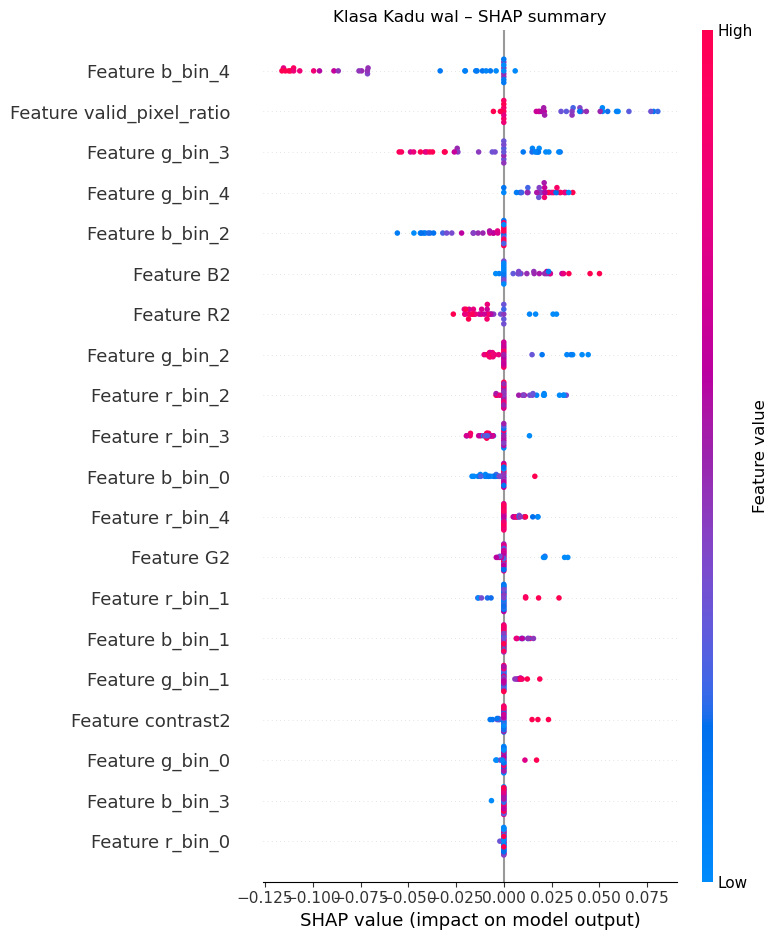

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

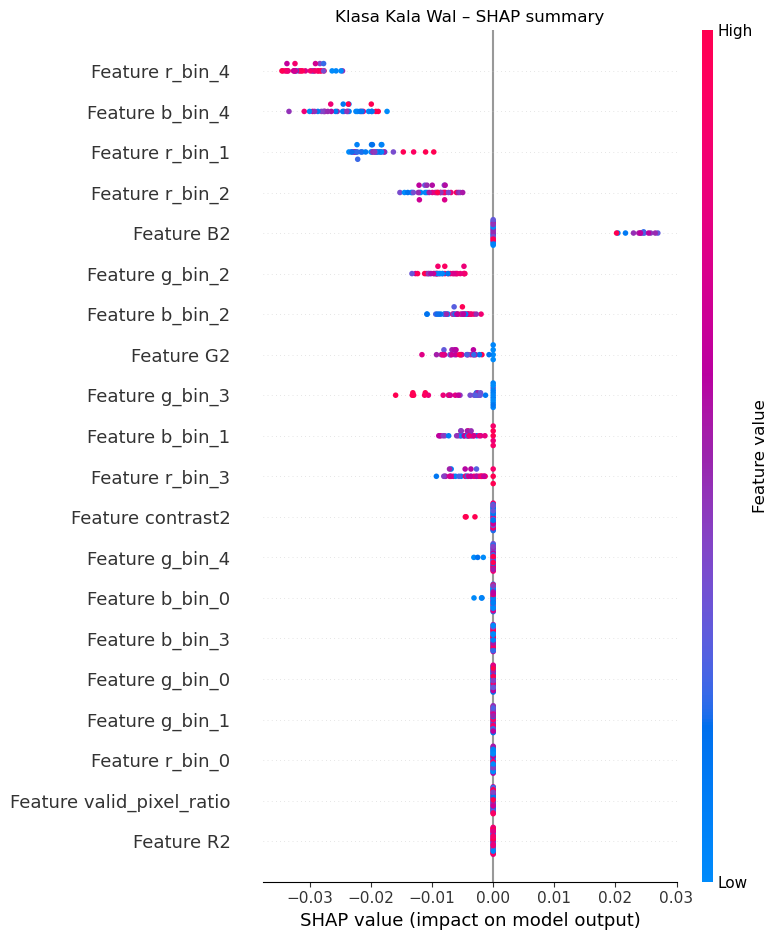

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

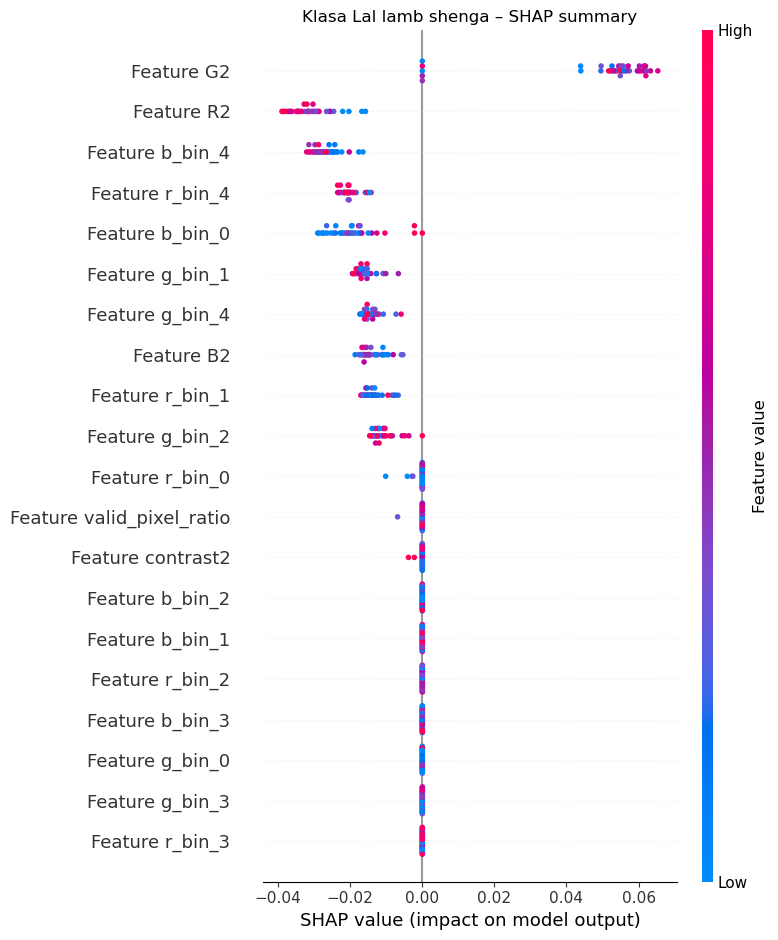

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

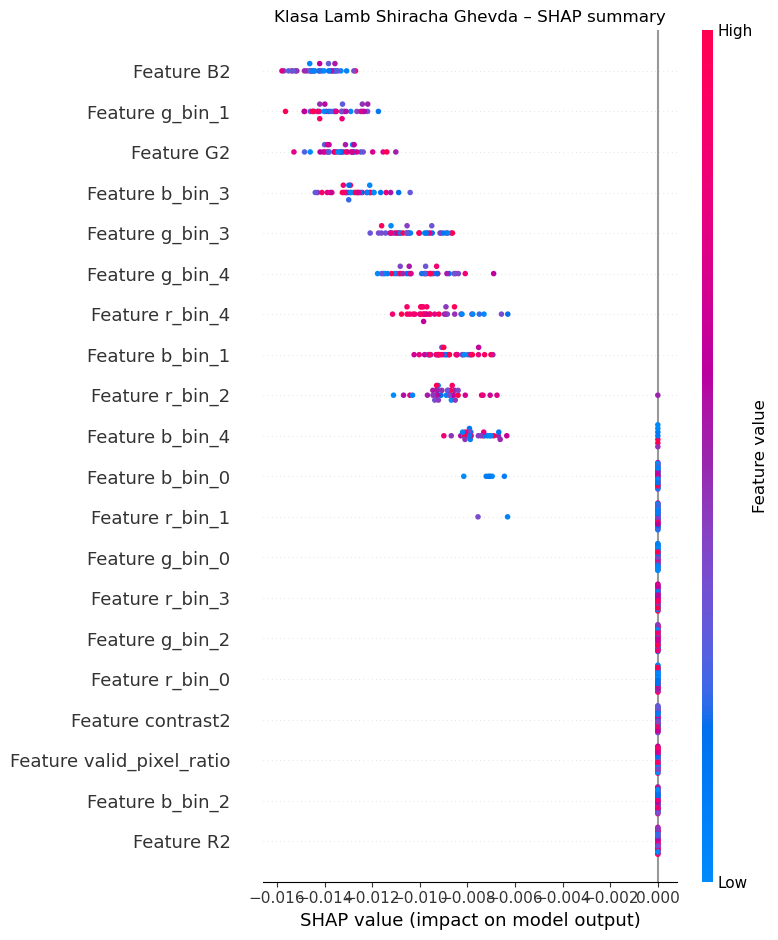

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

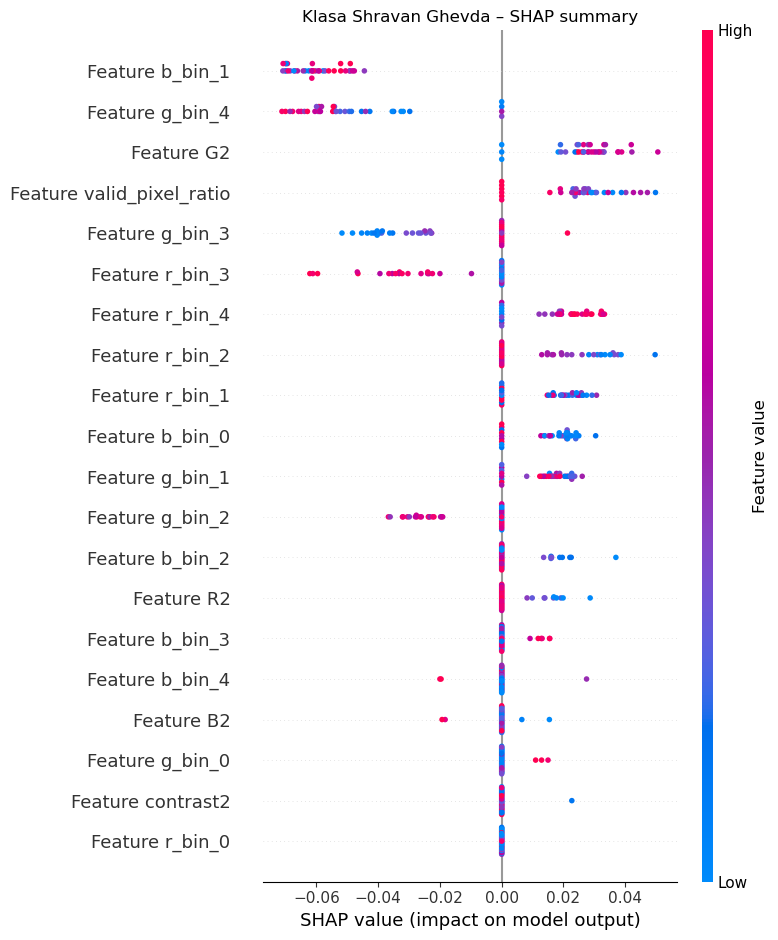

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

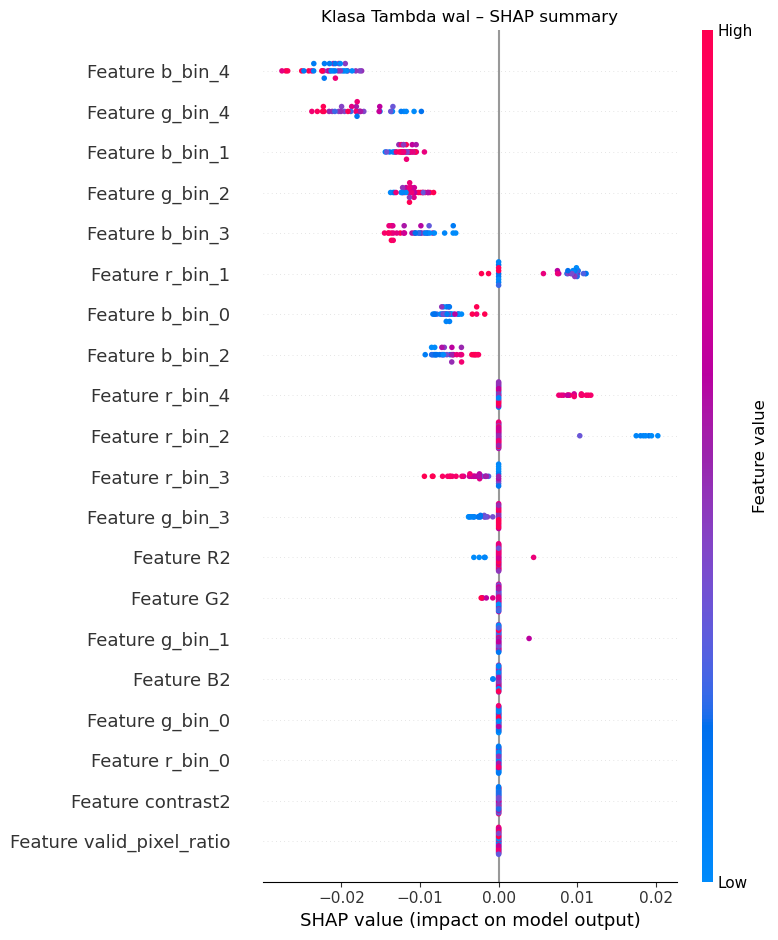

Using 108 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/36 [00:00<?, ?it/s]

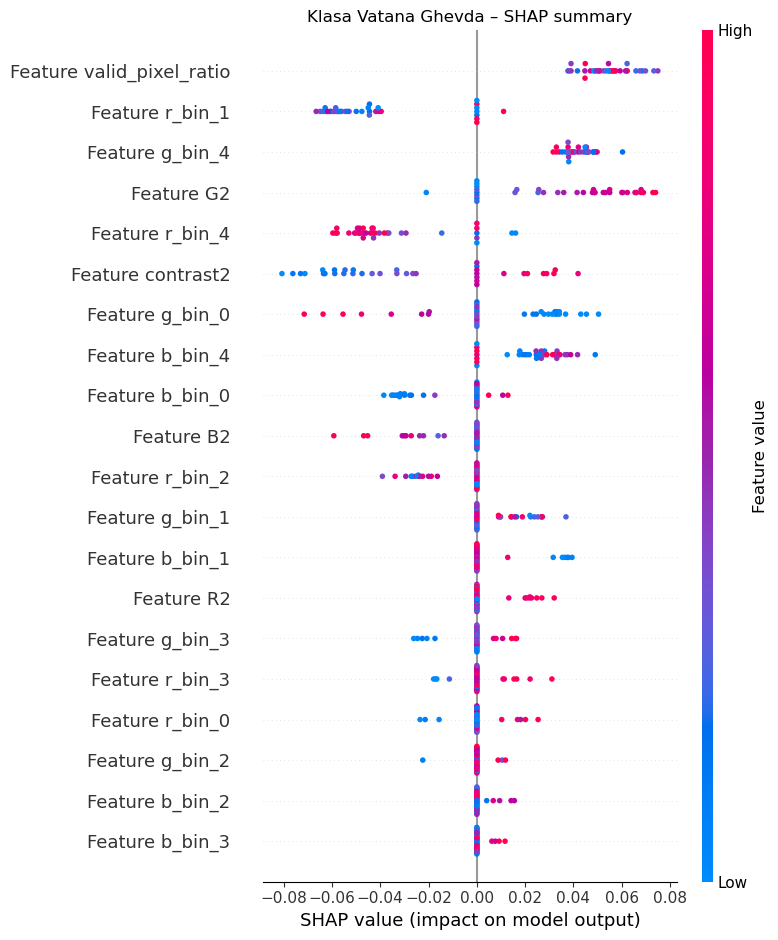

In [38]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Konwersja do DataFrame, żeby mieć nazwy cech
# feature_names = [f"Feature {i}" for i in range(X_train.shape[1])] #Done in reading data at the begining
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df  = pd.DataFrame(X_test,  columns=feature_names)



# 3. Przygotowanie próbki tła (background) 
background = X_train_df.sample(n=108,)

# 4. Podzbiór testowy do wyjaśniania 
n_explain = min(36, X_test_df.shape[0])
X_test_subset = X_test_df.iloc[:n_explain]

# 5. Dla każdej klasy osobno: KernelExplainer i summary_plot
shap_values_list = []
for i, cls in enumerate(best_voting.classes_):
    # explainer zwracający predict_proba[:, i]
    explainer_i = shap.KernelExplainer(
        lambda x: best_voting.predict_proba(x)[:, i],
        background.values
    )
    # obliczenie shap_values: (n_samples, n_features)
    shap_vals_i = explainer_i.shap_values(X_test_subset.values)
    shap_values_list.append(shap_vals_i)
    
    # summary_plot dla klasy i
    plt.figure()
    shap.summary_plot(
        shap_vals_i,
        X_test_subset,
        show=False
    )
    plt.title(f'Klasa {cls} – SHAP summary')
    plt.tight_layout()
    plt.show()
    




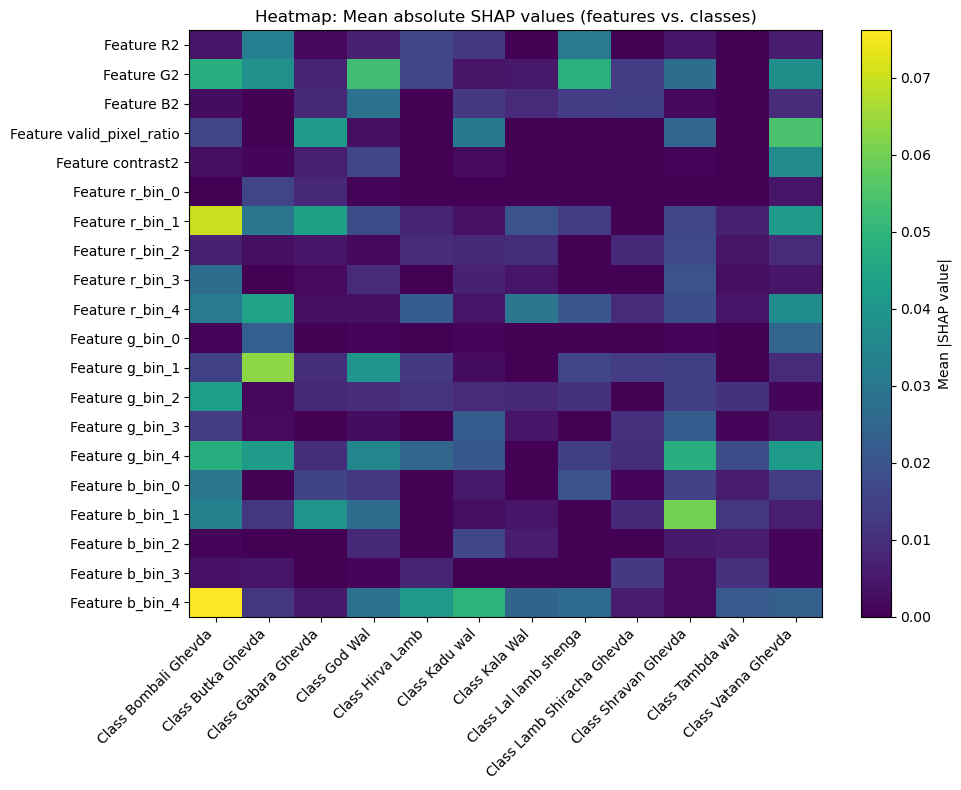

In [39]:
# 6. Podsumowanie: średnie |SHAP| dla każdej cechy i klasy w tabeli
#    Wynik: DataFrame o kształcie (n_features, n_classes)
mean_abs_shap = np.array([
    np.mean(np.abs(vals), axis=0)
    for vals in shap_values_list
])  # (n_classes, n_features)

# Transponujemy, aby wiersze = cechy, kolumny = klasy
df_summary = pd.DataFrame(
    mean_abs_shap.T,
    index=feature_names,
    columns=[f'Class {cls}' for cls in best_voting.classes_]
)

# 7. Heatmapa wpływu cech dla wszystkich klas
plt.figure(figsize=(10, 8))
plt.imshow(df_summary.values, aspect='auto')
plt.colorbar(label='Mean |SHAP value|')
plt.xticks(
    np.arange(len(df_summary.columns)),
    df_summary.columns,
    rotation=45,
    ha='right'
)
plt.yticks(
    np.arange(len(df_summary.index)),
    df_summary.index
)
plt.title('Heatmap: Mean absolute SHAP values (features vs. classes)')
plt.tight_layout()
plt.show()